In [12]:
import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [51]:
#!pip install pyyaml h5py

In [1]:
# Library import code from book
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Personal imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import time
import datetime

from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM
from keras.layers import Conv1D, Flatten, MaxPooling1D, GlobalMaxPool1D
from keras.preprocessing import text

from tensorflow import keras

In [2]:
if torch.cuda.is_available():
    # Create a device object for the GPU
    device = torch.device('cuda')
else:
    # Create a device object for the CPU
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
#!python -m wget http://nlp.stanford.edu/data/glove.6B.zip

## Loading the train, validation and test datasets

In [16]:
train = pd.read_csv("EmotionDatasetForNLP/data/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("EmotionDatasetForNLP/data/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("EmotionDatasetForNLP/data/test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

tweet_df = pd.read_csv("EmotionDatasetForNLP/data/tweet_emotions.csv")

go_df = pd.read_csv("EmotionDatasetForNLP/data/goemotions_formatted.csv")

In [17]:
# Combine training, validation, and test sets into one and make into DataFrame object
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,Sentiment
0,1536,i feel like im still just caught in the rat ra...,joy
1,1069,i will choose not to focus on him instead focu...,fear
2,12458,i wish i could say that i got a feeling that e...,joy
3,522,i have reported feeling marginalized intimidat...,fear
4,9896,i actually feel inside which is so dangerous b...,anger


In [18]:
tweet_df.tail()

,tweet_id,sentiment,content
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...
39999,1753919049,love,@mopedronin bullet train from tokyo the gf ...


In [19]:
go_df.head()

,Unnamed: 0,Text,ID,anger,fear,joy,sadness,surprise
0,0,WHY THE FUCK IS BAYLESS ISOING,eezlygj,1,0,0,0,0
1,1,To make her feel threatened,ed7ypvh,0,1,0,0,0
2,2,Dirty Southern Wankers,ed0bdzj,1,0,0,0,0
3,3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,0,0,0,0,1
4,4,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,0,0,1,0,0


## Dataset Preprocessing
Kaggle's Dataset Notebook provides this data visualizer funciton:

In [20]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))
    
    print("==================================================")
    
    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))
    
    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])
        
    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])
    
    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))
    
    print("==================================================")
    print("\nDescription of numerical variables")
    
    #### Describibg numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))
    
    print("==================================================")
    print("\nDescription of categorical variables")
    
    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))
    
    return

### EmotionDatasetForNLP

In [21]:
basic_eda(df)

Info : There are 3 columns in the dataset
Info : There are 2000 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['Input', 'Sentiment']
Numerical columns :  ['index']


,column_name,dtype
0,index,int64
1,Input,object
2,Sentiment,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,index,2000.0,6558.871,5047.020231,0.0,1559.5,5953.5,11119.5,15968.0



Description of categorical variables


,column_name,count,unique,top,freq
0,Input,2000,2000,i feel like im still just caught in the rat ra...,1
1,Sentiment,2000,6,joy,704


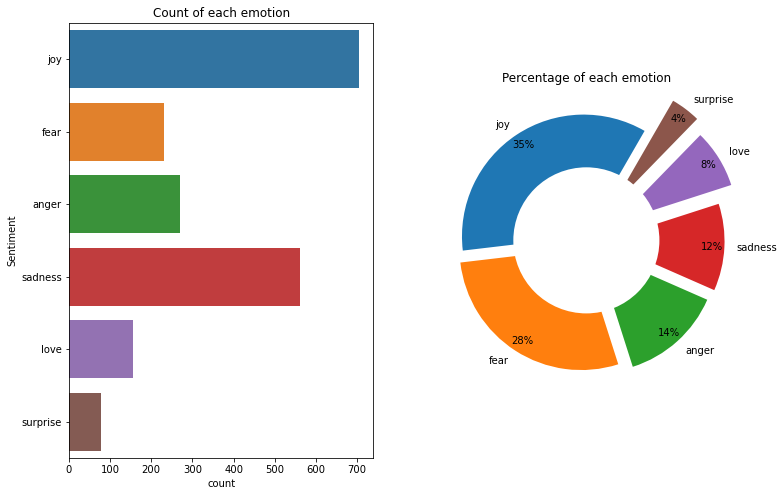

In [22]:
col = 'Sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])[:10]
labels = list(df[col].dropna().unique())[:10]
sizes = df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

### Tweet_Emotions

In [23]:
basic_eda(tweet_df)

Info : There are 3 columns in the dataset
Info : There are 40000 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['sentiment', 'content']
Numerical columns :  ['tweet_id']


,column_name,dtype
0,tweet_id,int64
1,sentiment,object
2,content,object



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,tweet_id,40000.0,1.845184e+09,1.188579e+08,1.693956e+09,1.751431e+09,1.855443e+09,1.962781e+09,1.966441e+09



Description of categorical variables


,column_name,count,unique,top,freq
0,sentiment,40000,13,neutral,8638
1,content,40000,39827,I just received a mothers day card from my lov...,14


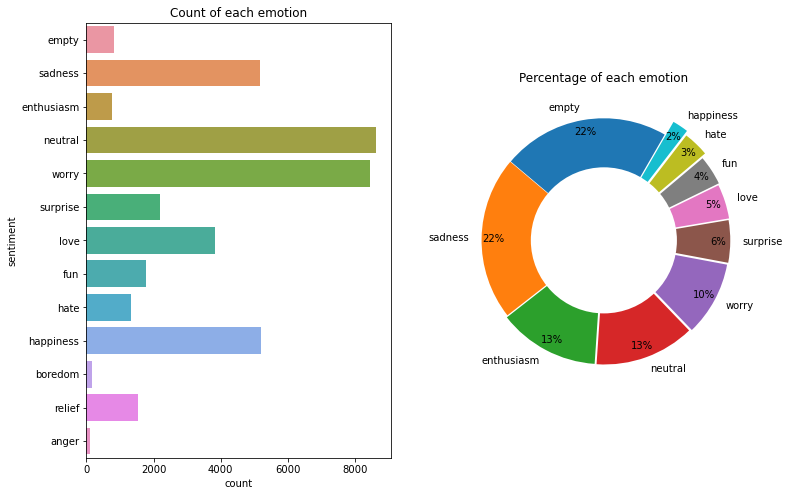

In [24]:
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(tweet_df[col].dropna().value_counts()))/sum(list(tweet_df[col].dropna().value_counts())))[::-1])[:10]
labels = list(tweet_df[col].dropna().unique())[:10]
sizes = tweet_df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = tweet_df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

Dataset does not have a balanced amount of datapoints for each class, which will cause the model to not converge. A solution is to remove under-represented classes and combine classes into one class.

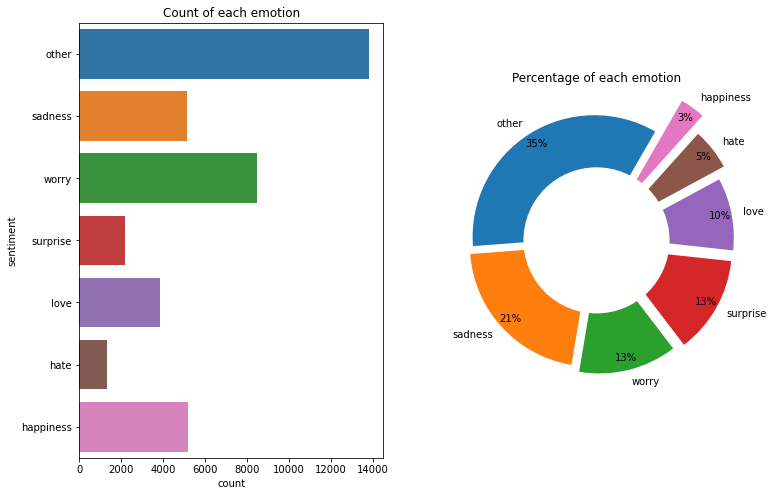

In [25]:
tweet_df['sentiment'] = tweet_df['sentiment'].apply(lambda x : x if x in ['happiness', 'sadness', 'worry', 'surprise', 'love', 'hate'] else "other")
col = 'sentiment'
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(tweet_df[col].dropna().value_counts()))/sum(list(tweet_df[col].dropna().value_counts())))[::-1])[:10]
labels = list(tweet_df[col].dropna().unique())[:10]
sizes = tweet_df[col].value_counts()[:10]
#ax.pie(sizes, explode=explode, colors=bo, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
sns.countplot(y =col, data = tweet_df, ax=ax1)
ax1.set_title("Count of each emotion")
ax2.set_title("Percentage of each emotion")
plt.show()

### GoEmotions Dataset

Robin worked on cleaning up the dataset to be similarly represented as the rest

In [26]:
basic_eda(go_df)

Info : There are 8 columns in the dataset
Info : There are 28427 rows in the dataset

Data type information of different columns
Info : There are 2 categorical columns
Info : There are 6 numerical columns
Categorical columns :  ['Text', 'ID']
Numerical columns :  ['Unnamed: 0', 'anger', 'fear', 'joy', 'sadness', 'surprise']


,column_name,dtype
0,Unnamed: 0,int64
1,Text,object
2,ID,object
3,anger,int64
4,fear,int64



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,Unnamed: 0,28427.0,14213.000000,8206.312387,0.0,7106.5,14213.0,21319.5,28426.0
1,anger,28427.0,0.180005,0.384198,0.0,0.0,0.0,0.0,1.0
2,fear,28427.0,0.024167,0.153571,0.0,0.0,0.0,0.0,1.0
3,joy,28427.0,0.589158,0.491995,0.0,0.0,1.0,1.0,1.0
4,sadness,28427.0,0.108488,0.311002,0.0,0.0,0.0,0.0,1.0



Description of categorical variables


,column_name,count,unique,top,freq
0,Text,28427,28301,Thank you.,13
1,ID,28427,28427,eezlygj,1


In [27]:
go_df.head()

,Unnamed: 0,Text,ID,anger,fear,joy,sadness,surprise
0,0,WHY THE FUCK IS BAYLESS ISOING,eezlygj,1,0,0,0,0
1,1,To make her feel threatened,ed7ypvh,0,1,0,0,0
2,2,Dirty Southern Wankers,ed0bdzj,1,0,0,0,0
3,3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,0,0,0,0,1
4,4,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,0,0,1,0,0


### Make each dataset categorical

In [28]:
encoded_conn = {'anger': 0, 'fear': 0, 'joy': 1, 'love': 1, 'sadness': 0, 'surprise': 1} 
encoded_anger = {'anger': 1, 'fear': 0, 'joy': 0, 'love': 0, 'sadness': 0, 'surprise': 0}
encoded_fear = {'anger': 0, 'fear': 1, 'joy': 0, 'love': 0, 'sadness': 0, 'surprise': 0}
encoded_joy = {'anger': 0, 'fear': 0, 'joy': 1, 'love': 0, 'sadness': 0, 'surprise': 0}
encoded_love = {'anger': 0, 'fear': 0, 'joy': 0, 'love': 1, 'sadness': 0, 'surprise': 0}
encoded_sadness = {'anger': 0, 'fear': 0, 'joy': 0, 'love': 0, 'sadness': 1, 'surprise': 0}
encoded_surprise = {'anger': 0, 'fear': 0, 'joy': 0, 'love': 0, 'sadness': 0, 'surprise': 1}

tweet_conn = {'hate': 0, 'worry': 0, 'happiness': 1, 'love': 1, 'sadness': 0, 'surprise': 1, 'other': 0} 
tweet_anger = {'hate': 1, 'worry': 0, 'happiness': 0, 'love': 0, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_fear = {'hate': 0, 'worry': 1, 'happiness': 0, 'love': 0, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_joy = {'hate': 0, 'worry': 0, 'happiness': 1, 'love': 0, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_love = {'hate': 0, 'worry': 0, 'happiness': 0, 'love': 1, 'sadness': 0, 'surprise': 0, 'other': 0}
tweet_sadness = {'hate': 0, 'worry': 0, 'happiness': 0, 'love': 0, 'sadness': 1, 'surprise': 0, 'other': 0}
tweet_surprise = {'hate': 0, 'worry': 0, 'happiness': 0, 'love': 0, 'sadness': 0, 'surprise': 1, 'other': 0}

In [29]:
df['anger'] = df.Sentiment.map(encoded_anger)
df['fear'] = df.Sentiment.map(encoded_fear)
df['joy'] = df.Sentiment.map(encoded_joy)
df['love'] = df.Sentiment.map(encoded_love)
df['sadness'] = df.Sentiment.map(encoded_sadness)
df['surprise'] = df.Sentiment.map(encoded_surprise)
df['connotation'] = df.Sentiment.map(encoded_conn)
df.head()

,index,Input,Sentiment,anger,fear,joy,love,sadness,surprise,connotation
0,1536,i feel like im still just caught in the rat ra...,joy,0,0,1,0,0,0,1
1,1069,i will choose not to focus on him instead focu...,fear,0,1,0,0,0,0,0
2,12458,i wish i could say that i got a feeling that e...,joy,0,0,1,0,0,0,1
3,522,i have reported feeling marginalized intimidat...,fear,0,1,0,0,0,0,0
4,9896,i actually feel inside which is so dangerous b...,anger,1,0,0,0,0,0,0


In [30]:
df.to_csv("EmotionDatasetForNLP/data/smallData_formatted.csv", index=False)

In [31]:
tweet_df['anger'] = tweet_df.sentiment.map(tweet_anger)
tweet_df['fear'] = tweet_df.sentiment.map(tweet_fear)
tweet_df['joy'] = tweet_df.sentiment.map(tweet_joy)
tweet_df['love'] = tweet_df.sentiment.map(tweet_love)
tweet_df['sadness'] = tweet_df.sentiment.map(tweet_sadness)
tweet_df['surprise'] = tweet_df.sentiment.map(tweet_surprise)
tweet_df['connotation'] = tweet_df.sentiment.map(tweet_conn)
tweet_df.rename(columns={'content': 'Input'}, inplace=True)
tweet_df.tail()

,tweet_id,sentiment,Input,anger,fear,joy,love,sadness,surprise,connotation
39995,1753918954,other,@JohnLloydTaylor,0,0,0,0,0,0,0
39996,1753919001,love,Happy Mothers Day All my love,0,0,0,1,0,0,1
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...,0,0,0,1,0,0,1
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,0,0,1,0,0,0,1
39999,1753919049,love,@mopedronin bullet train from tokyo the gf ...,0,0,0,1,0,0,1


In [18]:
#combined_df = pd.merge(df, tweet_df)
#combined_df

## Train-Test Split

In [79]:
# Stratify: Split in a stratified fashion using the class labels, which in this case is under the column header 'Sentiment'
train_data, test_data = train_test_split(df,test_size=0.3,random_state=101,shuffle=True,stratify=df.Sentiment)

In [33]:
# For using tweet dataset
train_data, test_data = train_test_split(tweet_df,test_size=0.3,random_state=101,shuffle=True,stratify=tweet_df.sentiment)

In [80]:
#train_data['Label'] = train_data.Sentiment.map(encoded_labels)
#test_data['Label'] = test_data.Sentiment.map(encoded_labels)
train_data.head()

,index,Input,Sentiment,anger,fear,joy,love,sadness,surprise,connotation
1924,10691,i found myself a place after looking for one f...,joy,0,0,1,0,0,0,1
988,884,i felt abandoned for what seemed like the mill...,sadness,0,0,0,0,1,0,0
560,13589,i feel i must remain faithful too,joy,0,0,1,0,0,0,1
531,1026,i have not conducted a survey but it is quite ...,sadness,0,0,0,0,1,0,0
629,12928,i remember him feeling discouraged,sadness,0,0,0,0,1,0,0


In [81]:
test_data.head()

,index,Input,Sentiment,anger,fear,joy,love,sadness,surprise,connotation
370,1845,i thought getting confirmation on publishing w...,fear,0,1,0,0,0,0,0
1278,12849,i thought i would love wearing s trousers but ...,joy,0,0,1,0,0,0,1
1586,9223,i spent the rest of the morning feeling discou...,sadness,0,0,0,0,1,0,0
1754,7585,i feel like i should be more bothered by this ...,anger,1,0,0,0,0,0,0
364,11465,i am feeling the strange mix of extremely prou...,fear,0,1,0,0,0,0,0


## Smaller Dataset Training

### Converting text to learnable values:
+ Bag of Words: Translates a string to a vector that is the length of number of words in the string, with each index
    representing the number of times a word occurs in a string.
    + Problem: Losses order of words, which is critical for the english language
+ Character Encoding: Encodes the individual characters in a string
    + Problem: Losses concept of words, becomes a very generative approach for our purpose
+ Word Embedding: Transforms each word into number vectors for a given string. The embeddings can be calculated for
    your given dataset, but you could just use pre-computed embeddings.
    + GloVe + word2vec: Embeddings contain a mathematical sense to their numbers by implementing semantic information in the embedding process. For instance, [king] - [man] + [woman] = [queen]

Fixed size vectors means padding needs to be added to the strings to ensure all will be the same length in words

In [82]:
# set parameters:
vocab_size = 1000
maxlen = 300
batch_size = 32
embedding_dims = 50
filters =250
kernel_size = 3
hidden_dims = 100
epochs = 10

In [83]:
# Split to X and Y
labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
X_train = train_data['Input']
X_train.head()
Y_train = train_data[labels]
Y_train.head()
X_test = test_data['Input']
Y_test = test_data[labels]
Y_test.head()

Yconn_train = train_data['connotation']
Yconn_test = test_data['connotation']
Yconn_train.head()

1924    1
988     0
560     1
531     0
629     0
Name: connotation, dtype: int64

In [84]:
# Tokenizer: Ensures inputs that are longer than max vocab size are removed to ensure same size vectors
tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

In [85]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [86]:
embeddings_index = dict()
f = open('glove/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [87]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [88]:
# Model (without GloVe embedding and originally made for binary classification)
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.5))
model.add(Conv1D(128,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(Flatten())
#model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 300, 50)           50000     
                                                                 
 dropout_12 (Dropout)        (None, 300, 50)           0         
                                                                 
 conv1d_14 (Conv1D)          (None, 298, 128)          19328     
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 149, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 147, 64)           24640     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 73, 64)           0         
 g1D)                                                 

In [89]:
# Model (with GloVe embedding)
model = Sequential()
model.add(Embedding(vocab_size,
                    100,
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False))
model.add(Dropout(0.5))
model.add(Conv1D(512,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 300, 100)          100000    
                                                                 
 dropout_14 (Dropout)        (None, 300, 100)          0         
                                                                 
 conv1d_16 (Conv1D)          (None, 300, 512)          154112    
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 150, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 150, 256)          393472    
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 75, 256)          0         
 g1D)                                                 

In [90]:
lr = 1e-5;
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [91]:
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=20,
          validation_data=(X_test, Y_test))

Epoch 1/20
44/44 [==============================] - 5s 99ms/step - loss: 1.8389 - accuracy: 0.2229 - val_loss: 1.7960 - val_accuracy: 0.2400
Epoch 2/20
44/44 [==============================] - 4s 93ms/step - loss: 1.7916 - accuracy: 0.2657 - val_loss: 1.7795 - val_accuracy: 0.3483
Epoch 3/20
44/44 [==============================] - 4s 93ms/step - loss: 1.7601 - accuracy: 0.3229 - val_loss: 1.7678 - val_accuracy: 0.3517
Epoch 4/20
44/44 [==============================] - 4s 92ms/step - loss: 1.7426 - accuracy: 0.3471 - val_loss: 1.7578 - val_accuracy: 0.3517
Epoch 5/20
44/44 [==============================] - 4s 89ms/step - loss: 1.7316 - accuracy: 0.3457 - val_loss: 1.7503 - val_accuracy: 0.3517
Epoch 6/20
44/44 [==============================] - 4s 89ms/step - loss: 1.7214 - accuracy: 0.3521 - val_loss: 1.7444 - val_accuracy: 0.3517
Epoch 7/20
44/44 [==============================] - 4s 90ms/step - loss: 1.7102 - accuracy: 0.3514 - val_loss: 1.7396 - val_accuracy: 0.3517
Epoch 8/20
44

In [81]:
model.save('models/CNN_smallData_Embedded.h5')

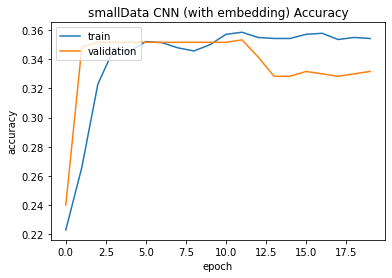

In [92]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('smallData CNN (with embedding) Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

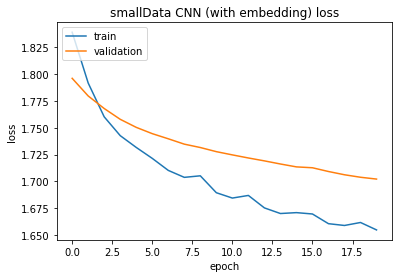

In [93]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('smallData CNN (with embedding) loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## GoEmotions Training

In [94]:
go_df

,Unnamed: 0,Text,ID,anger,fear,joy,sadness,surprise
0,0,WHY THE FUCK IS BAYLESS ISOING,eezlygj,1,0,0,0,0
1,1,To make her feel threatened,ed7ypvh,0,1,0,0,0
2,2,Dirty Southern Wankers,ed0bdzj,1,0,0,0,0
3,3,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,edvnz26,0,0,0,0,1
4,4,Yes I heard abt the f bombs! That has to be wh...,ee3b6wu,0,0,1,0,0
...,...,...,...,...,...,...,...,...
28422,28422,Added you mate well I’ve just got the bow and ...,edsb738,0,0,1,0,0
28423,28423,Always thought that was funny but is it a refe...,ee7fdou,0,0,0,0,1
28424,28424,What are you talking about? Anything bad that ...,efgbhks,1,0,0,0,0
28425,28425,"More like a baptism, with sexy results!",ed1naf8,0,0,1,0,0


In [95]:
train_data, test_data = train_test_split(go_df,test_size=0.3,random_state=101,shuffle=True)

In [96]:
# set parameters:
vocab_size = 1000
maxlen = 300
batch_size = 32
embedding_dims = 50
filters =250
kernel_size = 3
hidden_dims = 100
epochs = 10

In [97]:
# Split to X and Y
labels = ['anger', 'fear', 'joy', 'sadness', 'surprise']
X_train = train_data['Text']
X_train.head()
Y_train = train_data[labels]
Y_train.head()
X_test = test_data['Text']
Y_test = test_data[labels]
Y_test.head()

,anger,fear,joy,sadness,surprise
20825,0,0,1,1,0
18713,0,0,0,0,1
8383,0,0,1,0,0
10074,1,0,0,0,0
3108,0,0,0,1,1


In [98]:
# Tokenizer: Ensures inputs that are longer than max vocab size are removed to ensure same size vectors
tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

In [99]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [100]:
embeddings_index = dict()
f = open('EmotionDatasetForNLP/glove/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [101]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocab_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [105]:
# Model (with GloVe embedding), reduced complexity due to poorer performance
model = Sequential()
model.add(Embedding(vocab_size,
                    100,
                    input_length=maxlen,
                    weights=[embedding_matrix],
                    trainable=False))
model.add(Dropout(0.5))
model.add(Conv1D(512,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(256,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128,
                 kernel_size,
                 padding='same',
                 activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dense(len(labels), activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 300, 100)          100000    
                                                                 
 dropout_18 (Dropout)        (None, 300, 100)          0         
                                                                 
 conv1d_24 (Conv1D)          (None, 300, 512)          154112    
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 150, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 150, 256)          393472    
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 75, 256)          0         
 g1D)                                                 

In [103]:
lr = 1e-5;
opt = keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [104]:
history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=20,
          validation_data=(X_test, Y_test))

Epoch 1/20
622/622 [==============================] - 56s 89ms/step - loss: 1.5899 - accuracy: 0.5661 - val_loss: 1.5638 - val_accuracy: 0.5771
Epoch 2/20
622/622 [==============================] - 55s 89ms/step - loss: 1.4049 - accuracy: 0.5721 - val_loss: 1.4432 - val_accuracy: 0.5771
Epoch 3/20
622/622 [==============================] - 55s 89ms/step - loss: 1.3679 - accuracy: 0.5697 - val_loss: 1.4212 - val_accuracy: 0.5771
Epoch 4/20
622/622 [==============================] - 56s 90ms/step - loss: 1.3851 - accuracy: 0.5605 - val_loss: 1.4074 - val_accuracy: 0.5771
Epoch 5/20
622/622 [==============================] - 56s 89ms/step - loss: 1.4498 - accuracy: 0.5481 - val_loss: 1.3856 - val_accuracy: 0.5771
Epoch 6/20
622/622 [==============================] - 56s 90ms/step - loss: 1.5626 - accuracy: 0.5312 - val_loss: 1.3885 - val_accuracy: 0.5771
Epoch 7/20
622/622 [==============================] - 56s 90ms/step - loss: 1.8246 - accuracy: 0.5151 - val_loss: 1.4035 - val_accuracy:

In [73]:
model.save('models/CNN_GoEmotions_Embedded.h5')

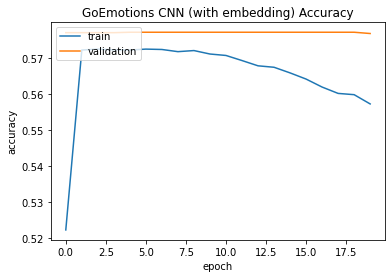

In [74]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('GoEmotions CNN (with embedding) Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

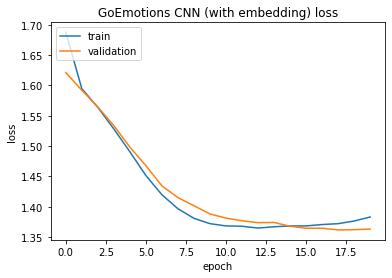

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('GoEmotions CNN (with embedding) loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()